In [11]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")

### 1. Подсчет длительности теста
Реализовать формулу подсчета длительности теста, сравнить ее с онлайн калькуляторами (например https://mindbox.ru/tools/ab-test-calculator/ ).

При сравнении оценить мощность критерия при указанном изменении и рассчитанном количестве наблюдений в выборке. 

In [2]:
def get_power(p_values, alpha=0.05):
    """Оценка мощности критерия, при условии, что значения p_value взяты при наличии 
    различий в сравниваемых выборках 
    """
    p_values = np.array(p_values)
    return p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100

def get_qq_plot(p_values, p_values_2, method='Линеаризация'):
    """Рисует распределение p-value"""
    p_values = np.array(p_values)
    p_values_2 = np.array(p_values_2)
    power = get_power(p_values, alpha=0.05)
    power_2 = get_power(p_values_2, alpha=0.05)
    probs = []
    probs_2 = []

    x = [0.01 * i for i in range(101)]
    for i in range(101):
        alpha_step = 0.01 * i
        probs.append(p_values[p_values < alpha_step].shape[0] / p_values.shape[0])
        probs_2.append(p_values_2[p_values_2 < alpha_step].shape[0] / p_values_2.shape[0])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.set_style("darkgrid")
    sns.scatterplot(x=x, y=probs, ax=axs[0])
    sns.lineplot(x=x, y=x, color='r', ax=axs[0])
    axs[0].set_title(f'Мощность: {power:.4}%')

    sns.scatterplot(x=x, y=probs_2, ax=axs[1])
    sns.lineplot(x=x, y=x, color='r', ax=axs[1]);
    axs[1].set_title(f'{method}. Мощность: {power_2:.4}%')

In [3]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k + 1) * z ** 2 * (sigma_1 ** 2 + sigma_2 ** 2 / k) / (delta_effect ** 2)
    return n

In [4]:
p = 0.5
effect = 0.2
sigma_1 = np.sqrt(p * (1 - p))
sigma_2 = np.sqrt((p + effect) * (1 - p - effect))
alpha = 0.05
beta = 0.2

duration(k=1, 
         delta_effect=effect, 
         sigma_1=sigma_1, 
         sigma_2=sigma_2, 
         alpha=alpha, 
         beta=beta
         )

180.524233890029

![image](2_2.png)

In [5]:
p = 0.5
effect = 0.05
sigma_1 = np.sqrt(p * (1 - p))
sigma_2 = np.sqrt((p + effect) * (1 - p - effect))
alpha = 0.05
beta = 0.1

duration(k=1, 
         delta_effect=effect, 
         sigma_1=sigma_1, 
         sigma_2=sigma_2, 
         alpha=alpha, 
         beta=beta
         )

4181.954378453365

![image](2_1.png)

Результаты алгоритма расчета длительности практически совпали с результатами предлагаемого mindbox решения 

### 2. Метод линеаризации
Реализовать метод линеаризации. Проверить для него корректность и мощность.

Мощность должна быть больше, чем просто на обычных значениях конверсии пользователей.


In [6]:
def linearization(loc_1, loc_2, scale_1, scale_2):
    n_exp = 1000
    p_values = []
    p_values_lin = []
    for _ in range(n_exp):
        records = []
        for i in range(100):
            n_views = int(sps.expon.rvs(loc=loc_1, scale=scale_1))
            clicks = sps.bernoulli.rvs(p=0.05, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "A"])
        for i in range(100):
            n_views = int(sps.expon.rvs(loc=loc_2, scale=scale_2))
            clicks = sps.bernoulli.rvs(p=0.05, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "B"])
        df_data = pd.DataFrame(records, columns=["views", "clicks", "cr", "group"])
        
        cr_A = df_data[df_data["group"] == "A"]["clicks"].sum() / df_data[df_data["group"] == "A"]["views"].sum()
        df_data["cr_lin"] = df_data["clicks"] - cr_A * df_data["views"]

        x_a = df_data[df_data["group"] == "A"]["cr"]
        x_b = df_data[df_data["group"] == "B"]["cr"]
        p_value = sps.ttest_ind(x_a, x_b).pvalue
        p_values.append(p_value)
        
        x_a_lin = df_data[df_data["group"] == "A"]["cr_lin"]
        x_b_lin = df_data[df_data["group"] == "B"]["cr_lin"]
        p_value_lin = sps.ttest_ind(x_a_lin, x_b_lin).pvalue
        p_values_lin.append(p_value_lin)
        
    get_qq_plot(p_values, p_values_lin, 'Линеаризация')


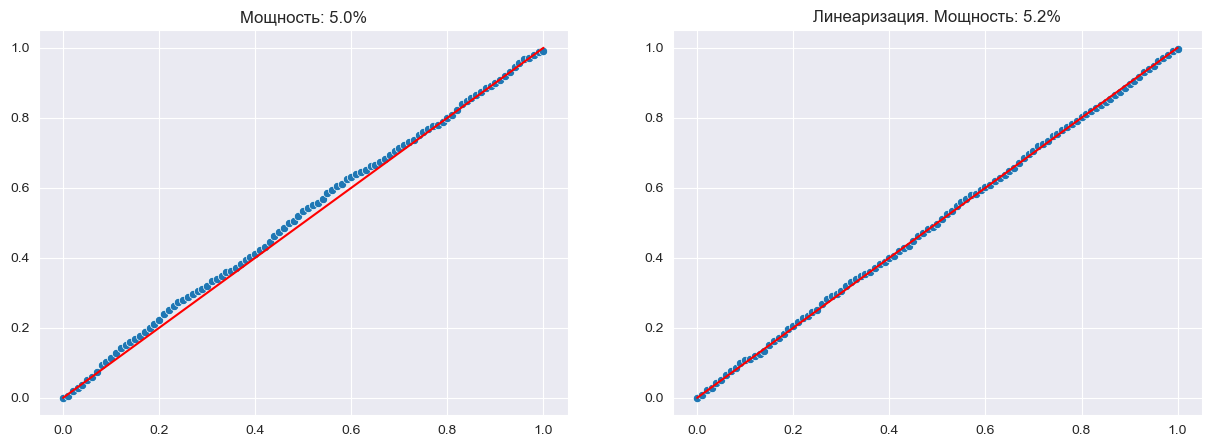

In [12]:
linearization(1, 1, 1, 1)

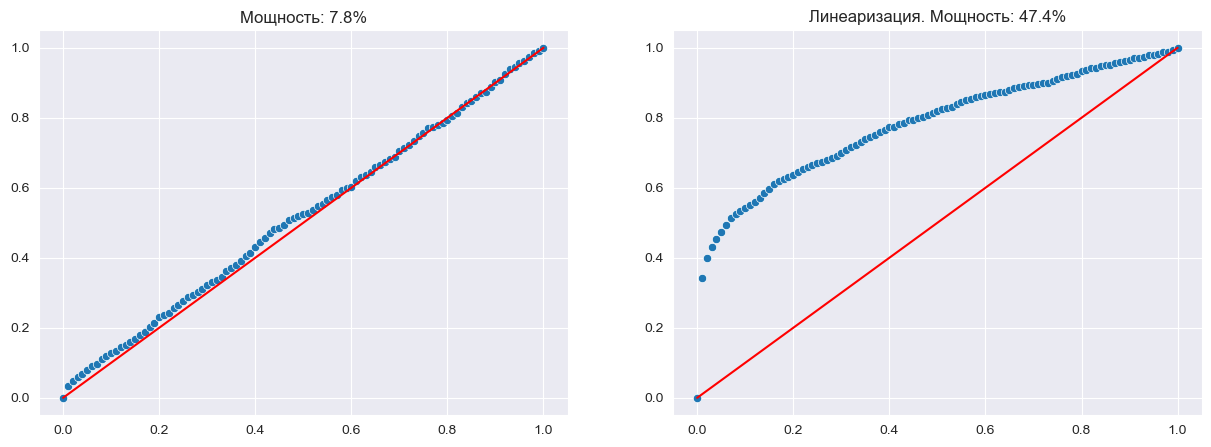

In [13]:
linearization(1, 10, 1, 1)

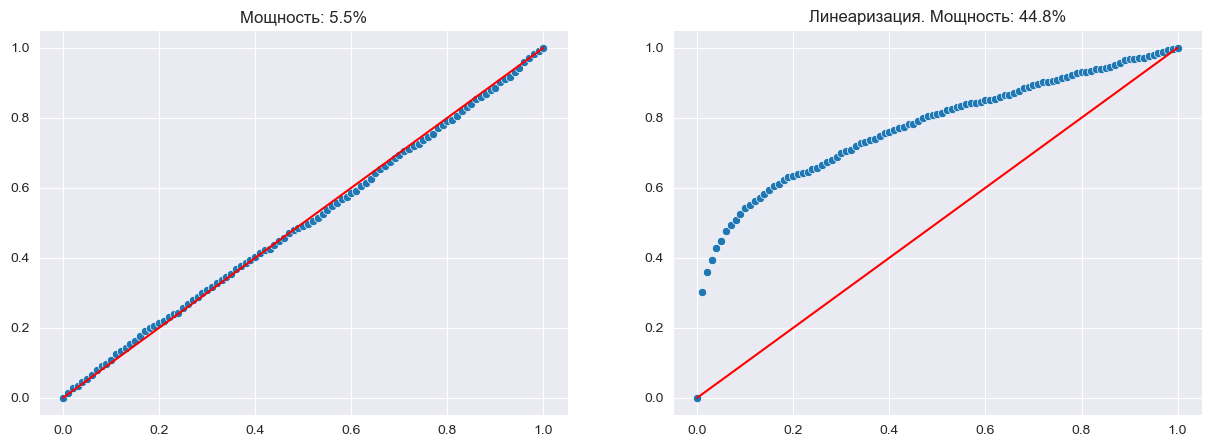

In [14]:
linearization(1, 1, 1, 10)

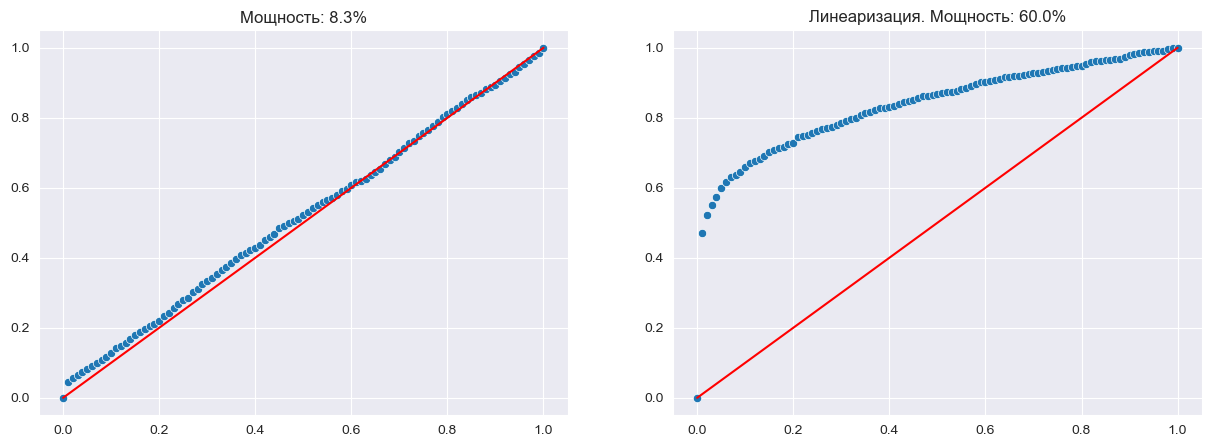

In [15]:
linearization(1, 10, 1, 10)

При линеаризации ratio-метрик мощность критерия значительно увеличивается.

### 3. CUPED
Реализовать метод CUPED. Проверить для него корректность и мощность.

Данные на этапе до A/B тесте необходимо сгенерировать один раз, далее синтетически генерировать только часть, связанную с проведением A/B-теста.

In [17]:
def cuped(loc_1, loc_2, scale_1, scale_2, loc_prev, scale_prev, corr=True):
    n_exp = 1000
    p_values = []
    p_values_cuped = []
    size = 1000

    # Pre_experiment
    pre_exp = sps.norm.rvs(loc=loc_prev, scale=scale_prev, size=size)
    for _ in range(n_exp):
        
        df_A = pd.DataFrame()
        df_A["user"] = [f"A_{x:5}" for x in range(size)]
        df_A["pre_exp"] = pre_exp
        df_A["payments"] = sps.norm.rvs(loc=loc_1, scale=scale_1, size=size)
        df_B = pd.DataFrame()
        df_B["pre_exp"] = pre_exp
        df_B["user"] = [f"B_{x:5}" for x in range(size)]
        df_B["payments"] = sps.norm.rvs(loc=loc_2, scale=scale_2, size=size)
        if corr:
            df_A["payments"] *= df_A["pre_exp"]
            df_B["payments"] *= df_B["pre_exp"]

        p_values.append(sps.ttest_ind(df_A["payments"], df_B["payments"]).pvalue)
        
        x_a = df_A["pre_exp"]
        x_b = df_B["pre_exp"]
        y_a = df_A["payments"]
        y_b = df_B["payments"]
        theta = np.cov(x_a, y_a)[0,1] / np.std(x_a)**2
        
        df_A["payments_cuped"] = df_A["payments"] - theta * df_A["pre_exp"]
        df_B["payments_cuped"] = df_B["payments"] - theta * df_B["pre_exp"]
        
        p_values_cuped.append(sps.ttest_ind(df_A["payments_cuped"], df_B["payments_cuped"]).pvalue)
    
    get_qq_plot(p_values, p_values_cuped, 'CUPED')

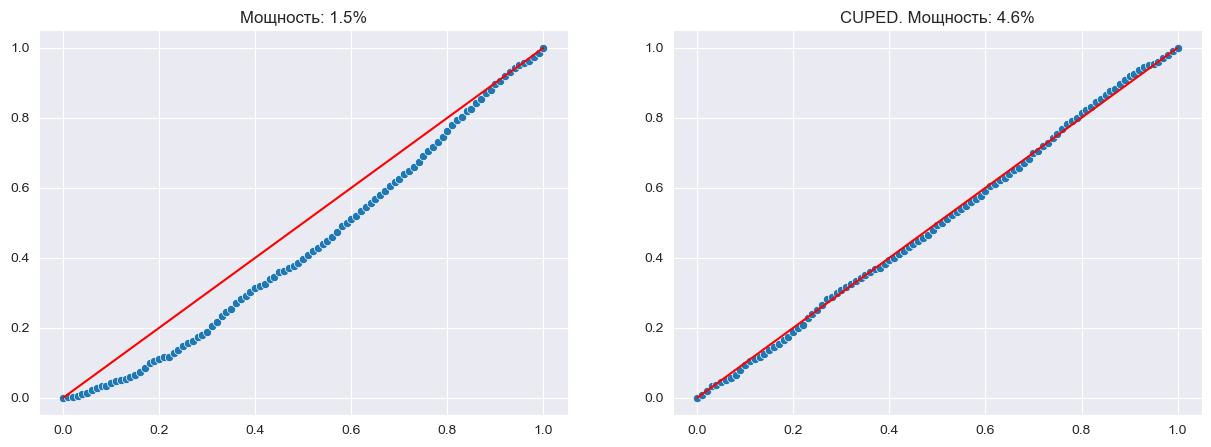

In [18]:
cuped(1, 1, 1, 1, 1, 1)

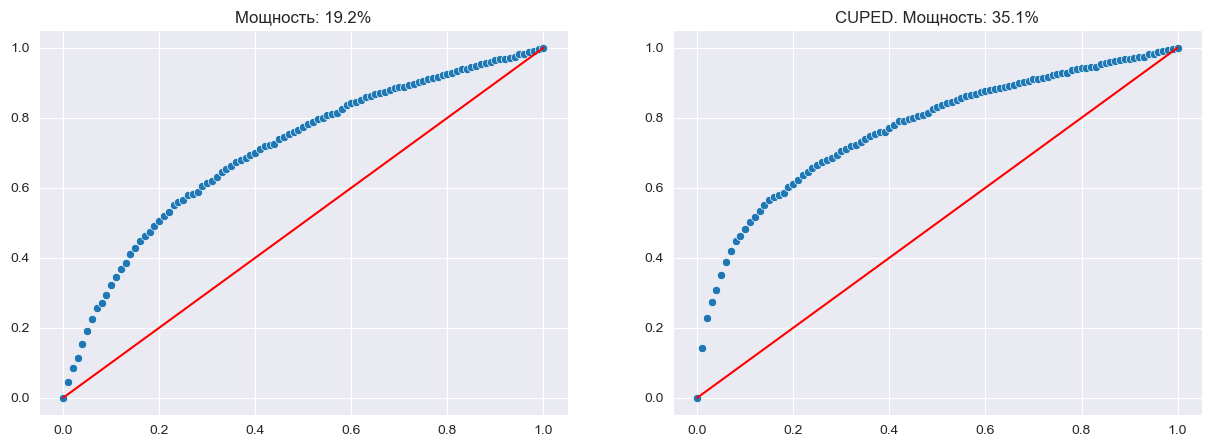

In [19]:
cuped(1, 1.1, 1, 1, 1, 1)

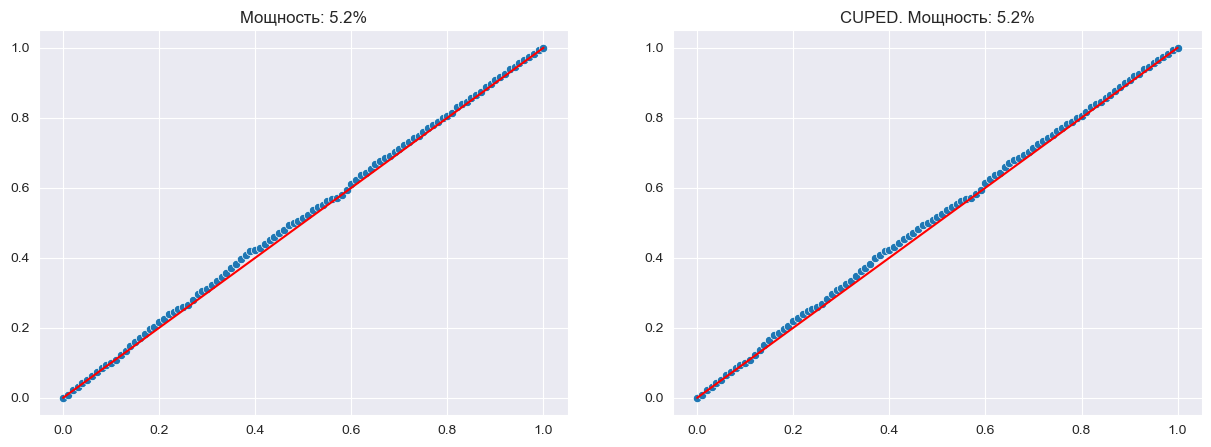

In [20]:
cuped(1, 1, 1, 10, 1, 1)

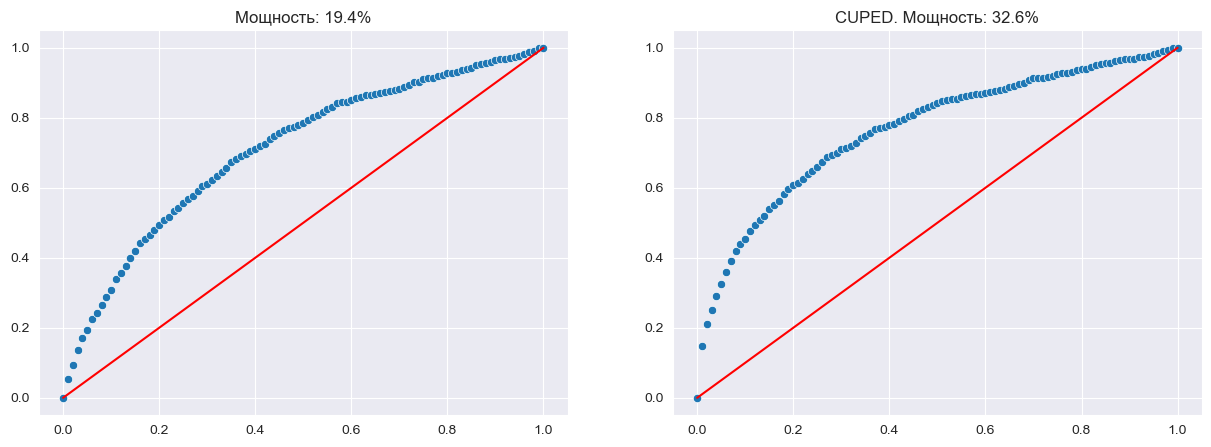

In [21]:
cuped(1, 1.1, 1, 1.1, 1, 1)

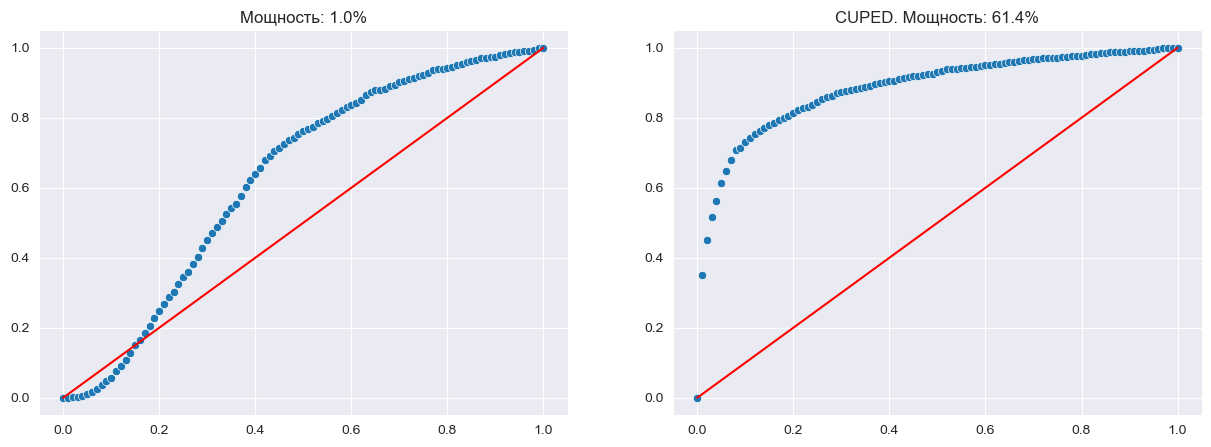

In [22]:
cuped(1, 1.01, 0.1, 0.1, 100, 20)

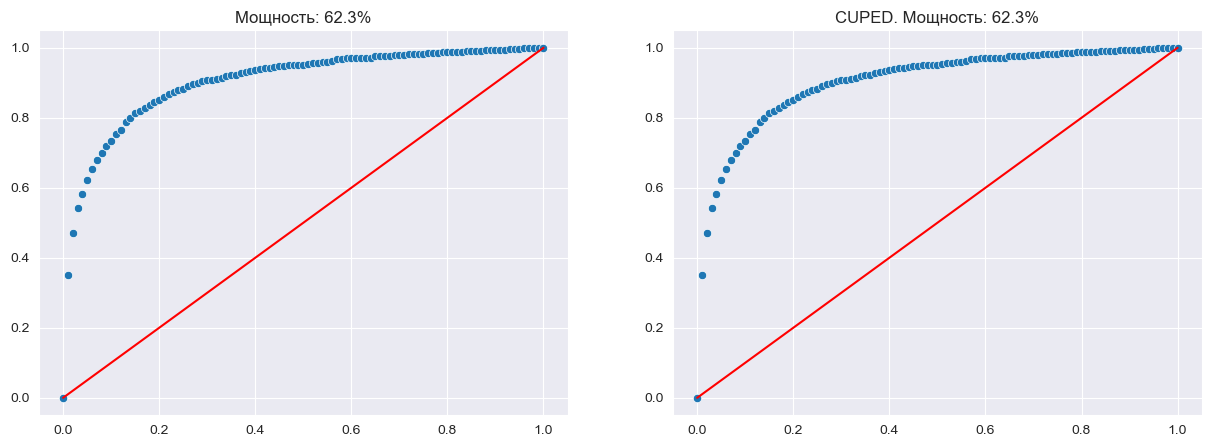

In [23]:
cuped(1, 1.01, 0.1, 0.1, 100, 20, False)

При корреляции с историческими данными метод CUPED дает бОльшую мощность.